# Groupe5 TP RANDOM FOREST


In [48]:
"""
Make the imports of python packages needed
"""
import pandas as pd
import numpy as np
from pprint import pprint
import scipy.stats as sps

In [49]:
dataset = pd.read_csv('mushrooms.csv',header=None)

In [50]:
dataset = dataset.sample(frac=1)
dataset.columns = ['target','cap-shape','cap-surface','cap-color','bruises','odor','gill-attachment','gill-spacing','gill-size','gill-color','stalk-shape','stalk-root','stalk-surface-above-ring','stalk-surface-below-ring','stalk-color-above-ring','stalk-color-below-ring','veil-type','veil-color','ring-number','ring-type','spore-print-color','population','habitat']

In [51]:
def entropy(target_col):
    elements,counts = np.unique(target_col,return_counts = True)
    entropy = np.sum([(-counts[i]/np.sum(counts))*np.log2(counts[i]/np.sum(counts)) for i in range(len(elements))])
    return entropy

In [52]:
def InfoGain(data,split_attribute_name,target_name="target"):
#Calculate the entropy of the total dataset
    total_entropy = entropy(data[target_name])
##Calculate the entropy of the dataset
#Calculate the values and the corresponding counts for the split attribute
    vals,counts= np.unique(data[split_attribute_name],return_counts=True)
#Calculate the weighted entropy
    Weighted_Entropy = np.sum([(counts[i]/np.sum(counts))*entropy(data.where(data[split_attribute_name]==vals[i]).dropna()[target_name]) for i in range(len(vals))])
#Calculate the information gain
    Information_Gain = total_entropy - Weighted_Entropy
    return Information_Gain

In [53]:
def ID3(data,originaldata,features,target_attribute_name="target",parent_node_class = None):
#Define the stopping criteria --> If one of this is satisfied, we want to return a leaf node#
#If all target_values have the same value, return this value
    if len(np.unique(data[target_attribute_name])) <= 1:
       
    #return np.unique(data[target_attribute_name])[0]#r the features in the dataset
        best_feature_index = np.argmax(item_values)
        best_feature = features[best_feature_index]
#Create the tree structure. The root gets the name of the feature (best_feature) with the maximum information
#gain in the first run
        tree = {best_feature:{}}
#Remove the feature with the best inforamtion gain from the feature space
        features = [i for i in features if i != best_feature]
#Grow a branch under the root node for each possible value of the root node feature
    for value in np.unique(data[best_feature]):
            value = value
#Split the dataset along the value of the feature with the largest information gain and therwith create sub_datasets
            sub_data = data.where(data[best_feature] == value).dropna()
#Call the ID3 algorithm for each of those sub_datasets with the new parameters --> Here the recursion comes in!
            subtree = ID3(sub_data,dataset,features,target_attribute_name,parent_node_class)
#Add the sub tree, grown from the sub_dataset to the tree under the root node
            tree[best_feature][value] = subtree
    return(tree)

In [54]:
def predict(query,tree,default = 'p'):
    for key in list(query.keys()):
        if key in list(tree.keys()):
            try:
                result = tree[key][query[key]]
            except:
                return default
            result = tree[key][query[key]]
        if isinstance(result,dict):
            return predict(query,result)
        else:
            return result

In [55]:
def train_test_split(dataset):
    training_data = dataset.iloc[:round(0.75*len(dataset))].reset_index(drop=True)#We drop the index respectively relabel the index
    #starting form 0, because we do not want to run into errors regarding the row labels / indexes
    testing_data = dataset.iloc[round(0.75*len(dataset)):].reset_index(drop=True)
    return training_data,testing_data
    training_data = train_test_split(dataset)[0]
    testing_data = train_test_split(dataset)[1]

In [56]:
#######Train the Random Forest model###########
def RandomForest_Train(dataset,number_of_Trees):
#Create a list in which the single forests are stored
    random_forest_sub_tree = []
#Create a number of n models
    for i in range(number_of_Trees):
#Create a number of bootstrap sampled datasets from the original dataset
        bootstrap_sample = dataset.sample(frac=1,replace=True)
#Create a training and a testing datset by calling the train_test_split function
        bootstrap_training_data = train_test_split(bootstrap_sample)[0]
        bootstrap_testing_data = train_test_split(bootstrap_sample)[1]
#Grow a tree model for each of the training data
#We implement the subspace sampling in the ID3 algorithm itself. Hence take a look at the ID3 algorithm above!
        random_forest_sub_tree.append(ID3(bootstrap_training_data,bootstrap_training_data,bootstrap_training_data.drop(labels=['target'],axis=1).columns))
        return random_forest_sub_tree
        random_forest = RandomForest_Train(dataset,50)

In [57]:
def RandomForest_Train(dataset,number_of_Trees):
#Create a list in which the single forests are stored
    random_forest_sub_tree = []
#Create a number of n models
    for i in range(number_of_Trees):
#Create a number of bootstrap sampled datasets from the original dataset
        bootstrap_sample = dataset.sample(frac=1,replace=True)
#Create a training and a testing datset by calling the train_test_split function
        bootstrap_training_data = train_test_split(bootstrap_sample)[0]
        bootstrap_testing_data = train_test_split(bootstrap_sample)[1]
#Grow a tree model for each of the training data
#We implement the subspace sampling in the ID3 algorithm itself. Hence take a look at the ID3 algorithm above!
        random_forest_sub_tree.append(ID3(bootstrap_training_data,bootstrap_training_data,bootstrap_training_data.drop(labels=['target'],axis=1).columns))
        return random_forest_sub_tree
        random_forest = RandomForest_Train(dataset,50)


In [58]:
#######Predict a new query instance###########
def RandomForest_Predict(query,random_forest,default='p'):
    predictions = []
    for tree in random_forest:
            predictions.append(predict(query,tree,default))
            return sps.mode(predictions)[0][0]
            query = testing_data.iloc[0,:].drop('target').to_dict()
            query_target = testing_data.iloc[0,0]
            print('target: ',query_target)
            prediction = RandomForest_Predict(query,random_forest)
            print('prediction: ',prediction)

In [59]:
#######Test the model on the testing data and return the accuracy###########
def RandomForest_Test(data,random_forest):
    data['predictions'] = None
    for i in range(len(data)):
        query = data.iloc[i,:].drop('target').to_dict()
        data.loc[i,'predictions'] = RandomForest_Predict(query,random_forest,default='p')
        accuracy = sum(data['predictions'] == data['target'])/len(data)*100
#print('The prediction accuracy is: ',sum(data['predictions']== data['target'])/len(data)*100,'%')
        return accuracy
        RandomForest_Test(testing_data,random_forest)

UnboundLocalError: local variable 'best_feature' referenced before assignment

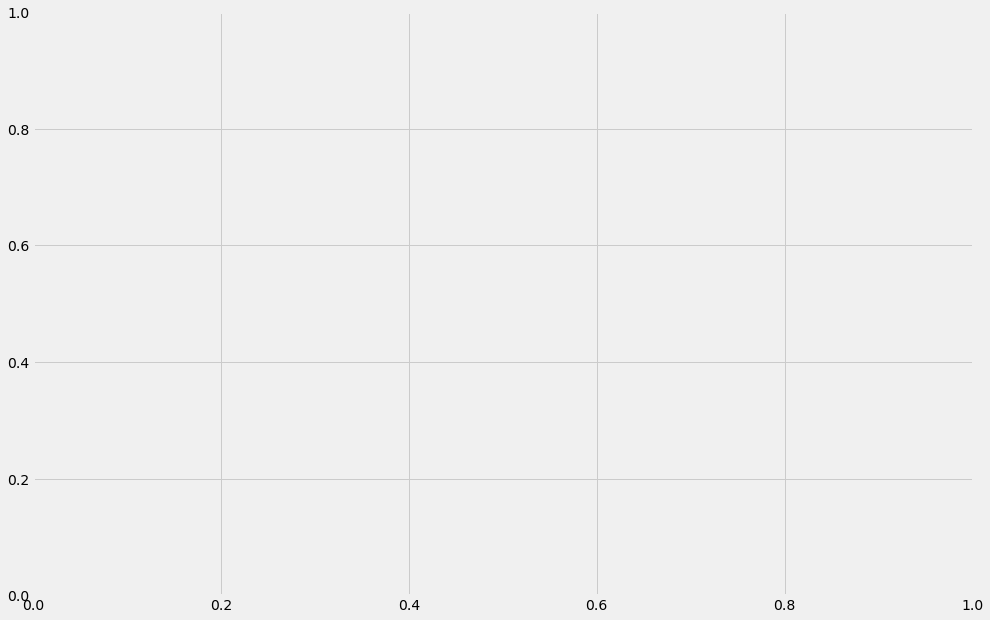

In [62]:
##################################################################
############################################
##########Plot the prediction accuracy with respect to the number of Trees in the random forests#############
##################################################################
############################################
import matplotlib.pyplot as plt
from matplotlib import style

style.use('fivethirtyeight')
fig = plt.figure(figsize=(15,10))
ax0 = fig.add_subplot(111)
accuracy = []

for i in range(1,11,1):
    random_forest = RandomForest_Train(dataset,i)
    accuracy.append(RandomForest_Test(testing_data,random_forest))
    for i in range(10,110,10):
        random_forest = RandomForest_Train(dataset,i)
        accuracy.append(RandomForest_Test(testing_data,random_forest))
    for i in range(100,1100,100):
        random_forest = RandomForest_Train(dataset,i)
        accuracy.append(RandomForest_Test(testing_data,random_forest))
        print(accuracy)
        ax0.plot(np.logspace(0,3,30),accuracy)
        ax0.set_yticks(np.linspace(50,100,50))
        ax0.set_title("Accuracy with respect to the numer of trees in therandom forest")
        ax0.set_xscale('log')
        ax0.set_xlabel("Number of Trees")
        ax0.set_ylabel('Accuracy(%)')

        plt.show()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import cross_validate
#Encode the feature values which are strings to integers
for label in dataset.columns:
    dataset[label] = LabelEncoder().fit(dataset[label]).transform(dataset[label])
    X = dataset.drop(['target'],axis=1)
    Y = dataset['target']
#Instantiate the model with 100 trees and entropy as splitting criteria
    Random_Forest_model = RandomForestClassifier(n_estimators=100,criterion="entropy")
#Cross validation
    accuracy = cross_validate(Random_Forest_model,X,Y,cv=10)['test_score']
    print('The accuracy is: ',sum(accuracy)/len(accuracy)*100,'%')